# Import Section

In [1]:
# from audapter.driver.filter_driver import FilterDriver
from pyroomacoustics import adaptive

In [2]:
import numpy as np
from scipy.fft import rfft, irfft, rfftfreq, fft, ifft, fftfreq
from nptyping import Array

In [81]:
from matplotlib import pylab as plt
import seaborn as sns

sns.set()
sns.set_context('paper')
sns.set_palette('Set2', 2)

## import Virtual Error Source

In [4]:
SOUND_FIELD = lambda x: 2. * x[:]

# from pysndfx import AudioEffectsChain
# AEC = AudioEffectsChain()
# SOUND_FIELD = AEC.reverb()

## import Warning Controller

In [5]:
from warnings import simplefilter
simplefilter('ignore')

# Define Global Variables

In [6]:
# Period
T_msec = 100

# Sample rate
fs = 44100
nyquist = fs//2

# Data size
N = fs * T_msec // 1000

# Filter Length
w_len = 10

# Maximum Amplifier
A_max = 256

# Amplifier
A = .8 * A_max

# Frequency of sound
w_sound = 440.

# Time
END_OF_TIME = 20
t = np.linspace(0, END_OF_TIME, fs*END_OF_TIME, dtype=np.float64)

## Make raw_signal

In [7]:
x_data = A * (np.sin(w_sound * (2 * np.pi * t)) + np.sin(w_sound * np.sqrt(2.) * (2 * np.pi * t ))) / 2.

# Main Section

## DOMAIN: FREQ

In [8]:
from pyroomacoustics.transform import STFT, synthesis
from pyroomacoustics import windows

In [9]:
# stft parameters
block_size = 256  # make sure the FFT size is a power of 2
hop = block_size // 2 + 1 # half overlap
window = windows.hann(block_size) 

# Create the STFT object + set filter and appropriate zero-padding
stft = STFT(block_size, hop=hop, analysis_window=window)
stft

## Make Buffer

In [10]:
x_buf = np.resize(x_data, [t.size//hop, hop])

y_buf = np.zeros_like(x_buf)

f_buf = np.zeros_like(y_buf)

d_buf = x_buf[:]
x_buf.shape, d_buf.shape

((6837, 129), (6837, 129))

## Preprocess

In [11]:
for i in range(w_len):
    y_now = x_buf[i]
    y_buf[i] = y_now[:]
    f_buf[i] = SOUND_FIELD(y_now[:])

In [12]:
X_buf = np.zeros((t.size//hop, hop), dtype=np.complex64)
for n in range(t.size//hop):
    stft.analysis(x_buf[n])
    X_buf[n] = stft.X[:]
X_buf.shape

(6837, 129)

In [13]:
driver = adaptive.SubbandLMS(num_taps=w_len, num_bands=hop, mu=0.3, nlms=True)

In [14]:
driver.X.shape

(10, 129)

In [15]:
for i in range(w_len, t.size//hop):
    d_block = d_buf[i-1]
    f_block = f_buf[i-1]
    
    stft.analysis(d_block)
    D = stft.X[:]
    stft.analysis(f_block)
    F = stft.X[:]
    
    driver.update(D, F)
    
    X_IN = X_buf[i-w_len : i, :]

    y_now = stft.synthesis(np.diag(np.dot(adaptive.hermitian(driver.W)[::-1], X_IN)))
    f_now = SOUND_FIELD(y_now)
    
    # Caching
    y_buf[i] = y_now[:]
    f_buf[i] = f_now[:]

# Plot Result

In [82]:
tail = t.size//1000

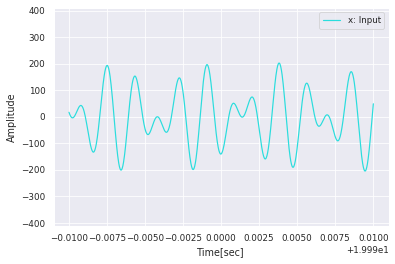

In [83]:
plt.plot(t[-tail:], x_data[-tail:], label="x: Input")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
# plt.grid()
plt.show()

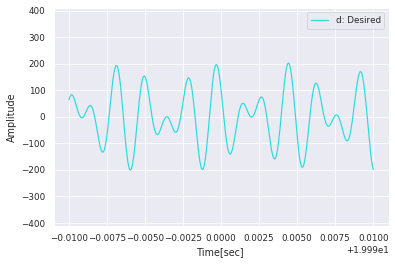

In [84]:
plt.plot(t[-tail:], d_buf.reshape(-1)[-tail:], label="d: Desired")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
# plt.grid()
plt.show()

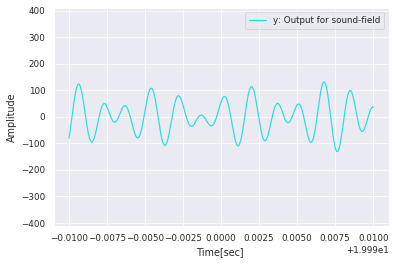

In [85]:
plt.plot(t[-tail:], y_buf.reshape(-1)[-tail:], label="y: Output for sound-field")
# plt.plot(t, y_cache, label="y: Output for sound-field")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
# plt.grid()
plt.show()

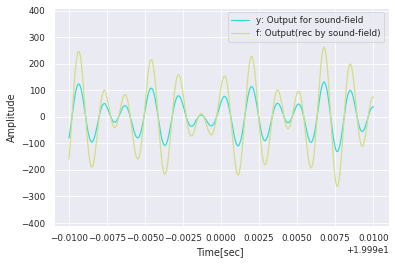

In [86]:
plt.plot(t[-tail:], y_buf.reshape(-1)[-tail:], label="y: Output for sound-field")
plt.plot(t[-tail:], f_buf.reshape(-1)[-tail:], label="f: Output(rec by sound-field)")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
# plt.grid()
plt.show()

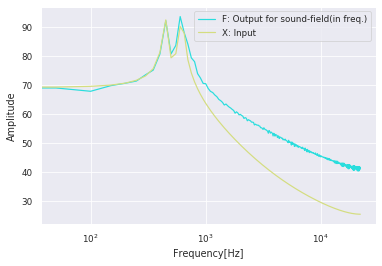

In [87]:
omega = rfftfreq(tail, d=1./fs)
plt.plot(omega, 20*np.log10(rfft(f_buf.reshape(-1)[-tail:])), label="F: Output for sound-field(in freq.)")
plt.plot(omega, 20*np.log10(rfft(x_data[-tail:])), label="X: Input")
plt.xlabel("Frequency[Hz]")
plt.ylabel("Amplitude")
plt.xscale('log')
plt.legend()
# plt.grid()
plt.show()